In [1]:
#import relavent libraries and packages
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from BinaryConnect import BinaryConnectCNN_SVHN
from BinaryConnect import custom_train_cnn
import time
import matplotlib.pyplot as plt
import scipy

In [2]:
#ensure using GPU to train the model to reduce training speed
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Compute the global mean and standard deviation
global_mean = np.mean(x_train, axis=(0, 1, 2))
global_std = np.std(x_train, axis=(0, 1, 2))

# Apply global contrast normalization
x_train = (x_train - global_mean) / (global_std + 1e-7)
x_test = (x_test - global_mean) / (global_std + 1e-7)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# ZCA Whitening
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(x_train)



c:\Users\chris\anaconda3\envs\envTF210\lib\site-packages\keras\preprocessing\image.py:1446: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [4]:
#display the shape of input data set to see if data is properly proprocessed
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [5]:

#Trainingparameters
batch_size = 50
epochs = 500  # Reduced for faster training on subset
validation_split = 5000 / x_train.shape[0]  # 
early_stopping_patience = 40


# Initialize lists to store metrics for plotting
stochastic_metrics = []
deterministic_metrics = []

# Train models with both deterministic and stochastic binarization
for deterministic in [False, True]:
    test_errors = []
    train_times = []
    trained_epochs = []

    # Create and compile the model
    model = BinaryConnectCNN_SVHN(deterministic)
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Split data into training and validation sets
    val_size = int(len(x_train) * validation_split)
    x_val, y_val = x_train[-val_size:], y_train[-val_size:]
    x_train_subset, y_train_subset = x_train[:-val_size], y_train[:-val_size]

    # Start timing model training
    start_time = time.time()

    # Train the model using custom train function
    train_losses, val_accuracies = custom_train_cnn(model, x_train_subset, y_train_subset, x_val, y_val, epochs, batch_size, early_stopping_patience)

    # Store the training metrics for plotting
    history_dict = {
        'loss': train_losses,
        'val_accuracy': val_accuracies
    }

    if deterministic:
        deterministic_metrics.append(history_dict)
    else:
        stochastic_metrics.append(history_dict)

    # Record training time and epochs
    train_time = time.time() - start_time
    train_times.append(train_time)
    trained_epochs.append(epochs)  # Since custom_train doesn't return history

    # Evaluate model on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    test_errors.append(1 - test_accuracy)


    print(
        f"Deterministic Binarization: {deterministic}\n"
        f"Average Test Error: {np.mean(test_errors)} +/- {np.std(test_errors)}\n"
        f"Average Training Time: {np.mean(train_times)} seconds\n"
        f"Average Number of Epochs: {np.mean(trained_epochs)}"
    )

    


Epoch 1/500
Epoch 1/500, Train Loss: 2.554903030395508, Train Accuracy: 11.628888130187988, Val Loss: 3.3692502975463867, Val Accuracy: 11.460000038146973
Epoch 2/500
Epoch 2/500, Train Loss: 2.39448618888855, Train Accuracy: 12.986665725708008, Val Loss: 3.508894205093384, Val Accuracy: 11.760000228881836
Epoch 3/500
Epoch 3/500, Train Loss: 2.3630006313323975, Train Accuracy: 13.008889198303223, Val Loss: 2.894770622253418, Val Accuracy: 12.579999923706055
Epoch 4/500
Epoch 4/500, Train Loss: 2.3339006900787354, Train Accuracy: 13.517777442932129, Val Loss: 3.0974745750427246, Val Accuracy: 12.25999927520752
Epoch 5/500
Epoch 5/500, Train Loss: 2.3151798248291016, Train Accuracy: 13.671110153198242, Val Loss: 2.7222437858581543, Val Accuracy: 12.219999313354492
Epoch 6/500
Epoch 6/500, Train Loss: 2.29565167427063, Train Accuracy: 14.315555572509766, Val Loss: 2.712303400039673, Val Accuracy: 12.540000915527344
Epoch 7/500
Epoch 7/500, Train Loss: 2.2753076553344727, Train Accuracy: 

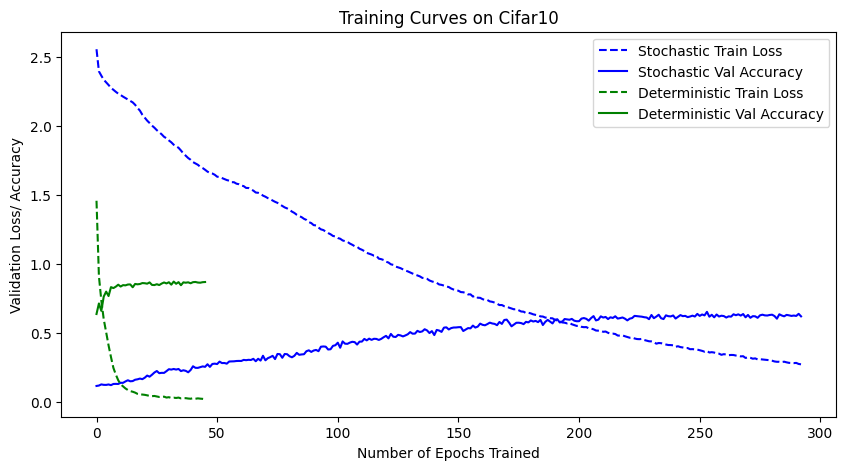

In [11]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot for stochastic binarization
for history in stochastic_metrics:
    plt.plot(history['loss'], 'b--')  # Training loss
    plt.plot(history['val_accuracy'], 'b')  # Validation accuracy

# Plot for deterministic binarization
for history in deterministic_metrics:
    plt.plot(history['loss'], 'g--')  # Training loss
    plt.plot(history['val_accuracy'], 'g')  # Validation accuracy

plt.title('Training Curves on Cifar10')
plt.xlabel('Number of Epochs Trained')
plt.ylabel('Validation Loss/ Accuracy')
plt.legend(['Stochastic Train Loss', 'Stochastic Val Accuracy',
            'Deterministic Train Loss', 'Deterministic Val Accuracy'], loc='upper right')
plt.show()